In [9]:
import pandas as pd
import numpy as np
import cvxpy as cp
from price import *
from pykalman import KalmanFilter
# from kalman import *

In [10]:
def calc_kalman(data,start):  
    data.dropna(inplace = True)
    indexs = data.index
    data.reset_index(drop = True, inplace = True)
    df = data.copy()
    name = df.columns.tolist()
    start_index = int(len(df)*start)
    delta = 0.1    #过程协方差矩阵的噪音
    transition_covariance = delta/(1-delta) * np.eye(2) #过程协方差矩阵(默认单位矩阵
    observation_matrices = np.vstack(
                        [np.ones(start_index), df.iloc[:start_index][name[1]]]
                    ).T[:,np.newaxis]    #观测矩阵

    kf = KalmanFilter(
                    n_dim_obs = 1,  #the dimensionality of the observation space
                    n_dim_state = 2,    #the dimensionality of the state space
                    initial_state_mean = np.zeros(2),   #mean of initial state distribution
                    initial_state_covariance = np.ones((2,2)),  #covariance of initial state distribution
                    transition_matrices = np.eye(2), #转移矩阵为单位阵
                    transition_covariance = transition_covariance,
                    observation_matrices = observation_matrices,
                    observation_covariance = 0.005
                    )
    filter_mean, filter_cov = kf.filter(df.iloc[:start_index][name[0]].values)  #alpha:1 beta:0
    
    for i in range(start_index, len(df)):
        observation_matrix = np.array([[1,df[name[1]].values[i]]])
        observation = df[name[0]].values[i]

        #以上一个时刻的状态，状态的协方差以及当前的观测值，得到当前状态的估计
        next_filter_mean, next_filter_cov = kf.filter_update(
                filtered_state_mean = filter_mean[-1],
                filtered_state_covariance = filter_cov[-1],
                observation = observation,
                observation_matrix = observation_matrix)

        filter_mean = np.vstack((filter_mean, next_filter_mean))
        filter_cov = np.vstack((filter_cov, next_filter_cov.reshape(1,2,2)))

    #得到alpha和beta
    df['alpha'] = pd.Series(filter_mean[:,0], index = df.index) #截距
    df['beta'] = pd.Series(filter_mean[:,1], index = df.index) #斜率
    df['predict'] = df['alpha'].shift() + df['beta'].shift()*df[name[0]]
    df.loc[:start_index,'predict'] = np.nan
    df.index = indexs
    return df['predict']

def calc_kalman_multi(data,start):  
    data.dropna(inplace = True)
    indexs = data.index
    data.reset_index(drop = True, inplace = True)
    df = data.copy()
    name = df.columns.tolist()
    start_index = int(len(df)*start)
    n = len(name)
    delta = 0.01    #过程协方差矩阵的噪音
    transition_covariance = delta/(1-delta) * np.eye(n) #过程协方差矩阵(默认单位矩阵
    observation_matrices = np.vstack(
                        [np.ones(start_index), df.iloc[:start_index][name[1]], df.iloc[:start_index][name[2]]]
                    ).T[:,np.newaxis]    #观测矩阵
    # Shape = observation_matrices.shape
    # observation_matrices = observation_matrices.reshape(Shape[0],1,Shape[1])
    # print(observation_matrices)
    kf = KalmanFilter(
                    n_dim_obs = 1,  #the dimensionality of the observation space
                    n_dim_state = n,    #the dimensionality of the state space
                    initial_state_mean = np.zeros(n),   #mean of initial state distribution
                    initial_state_covariance = np.ones((n,n)),  #covariance of initial state distribution
                    transition_matrices = np.eye(n), #转移矩阵为单位阵
                    transition_covariance = transition_covariance,
                    observation_matrices = observation_matrices,
                    observation_covariance = 0.005
                    )
    filter_mean, filter_cov = kf.filter(df.iloc[:start_index][name[0]].values)  #alpha:1 beta:0
    
    for i in range(start_index, len(df)):
        observation_matrix = np.array([[1,df[name[1]].values[i],df[name[2]].values[i]]])
        observation = df[name[0]].values[i]

        #以上一个时刻的状态，状态的协方差以及当前的观测值，得到当前状态的估计
        next_filter_mean, next_filter_cov = kf.filter_update(
                filtered_state_mean = filter_mean[-1],
                filtered_state_covariance = filter_cov[-1],
                observation = observation,
                observation_matrix = observation_matrix)

        filter_mean = np.vstack((filter_mean, next_filter_mean))
        filter_cov = np.vstack((filter_cov, next_filter_cov.reshape(1,n,n)))

    #得到alpha和beta
    df['alpha'] = pd.Series(filter_mean[:,0], index = df.index) #截距
    df['beta_1'] = pd.Series(filter_mean[:,1], index = df.index) #斜率
    df['beta_2'] = pd.Series(filter_mean[:,2], index = df.index) #斜率
    df['predict'] = df['alpha'].shift() + df['beta_1'].shift()*df[name[1]] + df['beta_2'].shift()*df[name[2]]
    df.loc[:start_index,'predict'] = np.nan
    df.index = indexs
    return df['predict'] 

In [11]:
# Import data
df = pd.read_csv('data/stock_price.csv', index_col = 0, header=[0,1])

In [12]:
close_price = df[['Adj Close']]
close_price.columns = close_price.columns.droplevel(0)
volume = df[['Volume']]
volume.columns = volume.columns.droplevel(0)
volume
close_price = close_price.drop('PGHD', axis = 1)
volume = volume.drop('PGHD', axis = 1)

In [13]:
actual_R_mat = close_price.pct_change()
actual_R_mat = actual_R_mat[1:]
actual_R_mat

,AAPL,ABBV,AMZN,AVGO,CVX,GOOG,GOOGL,JNJ,JPM,KO,...,META,MRK,MSFT,NVDA,PEP,PFE,TSLA,UNH,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-25 00:00:00,0.003615,0.008981,-0.006712,-0.007822,-0.008253,-0.000827,-0.000827,-0.000753,-0.005330,0.001998,...,-0.023319,-0.004784,-0.003186,-0.005609,-0.010300,-0.007752,0.024850,0.007345,0.024424,-0.003024
2013-03-26 00:00:00,-0.005263,0.022635,0.016757,0.007601,0.006657,0.003434,0.003434,0.014684,0.002473,0.014207,...,0.003183,0.016022,0.000000,0.007252,0.014005,0.015625,0.008793,0.014400,0.021097,0.012469
2013-03-27 00:00:00,-0.019647,-0.001493,0.019169,-0.004191,-0.006530,-0.012013,-0.012013,0.005195,-0.017886,-0.011551,...,0.034907,-0.006532,0.007457,0.012000,-0.007983,0.001399,0.007924,0.017430,0.007166,0.004993
2013-03-28 00:00:00,-0.020837,0.015691,0.004485,0.007856,-0.011399,-0.010552,-0.010552,0.003200,-0.006489,0.005470,...,-0.019548,0.002267,0.008460,0.014229,0.010474,0.007682,-0.007075,0.010420,0.006996,-0.005189
2013-04-01 00:00:00,-0.031062,0.008337,-0.018312,-0.016147,0.006649,0.008814,0.008814,0.004906,0.007797,0.000247,...,-0.001955,0.003394,0.000000,-0.032736,-0.000127,-0.000693,0.159409,0.030764,-0.014661,0.007325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-15 00:00:00,0.002621,0.001365,0.013912,-0.010151,-0.043294,0.024403,0.022773,0.002794,-0.047244,0.006663,...,0.019225,0.006170,0.017830,0.006857,0.017864,0.009524,-0.015333,0.001830,-0.010473,-0.049748
2023-03-16 00:00:00,0.018694,0.008049,0.039917,0.016708,0.003186,0.046815,0.043804,-0.002073,0.019414,0.005503,...,0.036308,-0.002694,0.040537,0.054194,-0.000679,0.002234,0.020394,0.014159,0.004991,-0.005806
2023-03-17 00:00:00,-0.005454,-0.006954,-0.010896,-0.008688,-0.012639,0.013753,0.012959,-0.010712,-0.037782,-0.004643,...,-0.045479,-0.030184,0.011694,0.007204,-0.007818,-0.006688,-0.021724,-0.005339,-0.000276,-0.011779


In [14]:
res1 = pd.DataFrame()
res2 = pd.DataFrame()
for fid in close_price.columns:
    print(fid)
    temp_close = close_price[fid]
    temp_volume = volume[fid]
    data = pd.DataFrame({'target':temp_close.shift(-1)/temp_close-1,'return':temp_close/temp_close.shift()-1,'return_vol':temp_volume/temp_volume.shift()-1})
    data.index = temp_close.index.values
    a = pd.DataFrame({fid:calc_kalman(data,0.4)})
    res1 = pd.concat([res1, a], axis = 1)
    a = pd.DataFrame({fid:calc_kalman_multi(data,0.4)})
    # res2 = pd.concat([res2, a], axis = 1)
    # res2[fid] = calc_kalman_multi(data,0.4)
res1.head()

AAPL
ABBV
AMZN
AVGO
CVX
GOOG
GOOGL
JNJ
JPM
KO
LLY
MA
META
MRK
MSFT
NVDA
PEP
PFE
TSLA
UNH
V
XOM


,AAPL,ABBV,AMZN,AVGO,CVX,GOOG,GOOGL,JNJ,JPM,KO,...,META,MRK,MSFT,NVDA,PEP,PFE,TSLA,UNH,V,XOM
2013-03-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
test_df = close_price.loc['2013-03-22 00:00:00': '2014-03-22 00:00:00', :]

## Optimization Model

In [40]:
def NPM(r, his_r, x_tilde, theta, c):
    '''
    param r [ndarray]: vector of predicted return at period t
    param his_r [ndarray]: 2d vector of return for the past W periods; his_r[i][j] = price 
    param x_tilde [ndarray]: investment weights at the end of period t-1
    param theta [float]: acceptable risk level in the range of (0, 1), smaller theta could lead to infeasible solution
    param c [float]: transacion cost in the range of (0, 1)

    '''
    M = len(r) # Number of assets in the portfolio
    W = len(his_r) # Number of recents prices used to measure risk
    
    # Define variables
    u = cp.Variable(M)
    v = cp.Variable(M)
    d = cp.Variable(W)
    g = cp.Variable(W)
    
    # Define Objective
    objective = cp.Maximize(r @ x_tilde + (x_tilde - c/2) @ u - (x_tilde + c/2) @ v)
    
    # Define constraints
    constraints = [cp.sum(d + g) <= W * theta,
                    cp.sum(u - v) == 0,
                    -(u - v + x_tilde) <= 0,
                    u - v + x_tilde <= 1,
                    u >= 0, v >= 0, d >= 0, g >= 0]
    for j in range(W):
        constraints += [(his_r[-1-j] - r) @ u + (his_r[-1-j] - r) @ v - d[j] <= (r - his_r[-1-j]) @ x_tilde,
                        (r - his_r[-1-j]) @ u + (r - his_r[-1-j]) @ v - d[j] <= (his_r[-1-j] - r) @ x_tilde]
        
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose = False)
#     print('problem status', problem.status)
#     constraints_value = [constraint.value for constraint in constraints]
#     print(constraints_value)
        
    return problem, u.value, v.value, d.value, g.value

Algorithm

In [65]:
weight_mat = []
assets = close_price.columns
pred_R_mat = res1 + 1
actual_R_mat = actual_R_mat 
N = 100 # Number
num_his = 6 # Number of historical days
init_weight = np.ones(len(assets)) / len(assets)
theta = 1
c = 0.00001
start_day = pred_R_mat.iloc[:, 1].first_valid_index()
print(start_day)
start_day = pred_R_mat.index.get_loc(start_day)

w = init_weight
for t in range(start_day, start_day + N):
    predicted_return = np.array(pred_R_mat.iloc[t][assets]) * w
    historial_w_actual_returns = actual_R_mat.iloc[t - num_his : t, :][assets]
    historial_w_actual_returns = historial_w_actual_returns.values
    problem, u, v, d, g = NPM(predicted_return, historial_w_actual_returns, w, theta, c)
#     print('u', u)
#     print('v', v)
    w = w + u - v
    weight_mat.append(w)
    print('w', w)

2017-03-23 00:00:00
w [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
w [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
w [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
w [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545

w [0.04545455 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
w [0.04545455 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545454 0.04545455]
w [0.04545455 0.04545454 0.04545454 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545454 0.04545455]
w [0.04545455 0.04545454 0.04545454 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545454 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545454 0.04545455]
w [0

w [0.04545621 0.04545402 0.0454536  0.04545435 0.04545469 0.04545433
 0.04545436 0.04545374 0.0454546  0.04545444 0.04545451 0.04545421
 0.04545455 0.04545373 0.04545425 0.04545621 0.04545478 0.04545447
 0.04545568 0.04545442 0.04545391 0.04545493]
w [0.04545637 0.045454   0.04545353 0.04545433 0.04545469 0.04545431
 0.04545435 0.04545369 0.04545459 0.04545443 0.0454545  0.04545419
 0.04545454 0.04545368 0.04545423 0.04545637 0.04545478 0.04545445
 0.04545575 0.0454544  0.04545387 0.04545494]
w [0.04545657 0.04545396 0.04545345 0.04545431 0.04545468 0.04545429
 0.04545433 0.04545362 0.04545458 0.04545441 0.04545449 0.04545417
 0.04545453 0.04545362 0.04545421 0.04545657 0.04545478 0.04545444
 0.04545584 0.04545439 0.04545383 0.04545494]
w [0.04545685 0.0454539  0.04545332 0.04545428 0.04545468 0.04545426
 0.0454543  0.04545352 0.04545457 0.04545439 0.04545447 0.04545413
 0.04545452 0.04545353 0.04545417 0.04545685 0.04545479 0.04545442
 0.04545596 0.04545436 0.04545376 0.04545496]
w [0

In [69]:
signal = pd.DataFrame(np.array(weight_mat), columns = assets, index = close_price.index[start_day : start_day + N])

In [72]:
import matplotlib.pyplot as plt

In [79]:
result = signal*actual_R_mat
result['yield'] = result.apply(lambda x: x.sum(), axis = 1)
result['netvalue'] = result['yield'].cumsum() + 1
result['draw'] = np.maximum.accumulate(result['netvalue']) - result['netvalue']


In [84]:
result.reset_index(inplace = True)

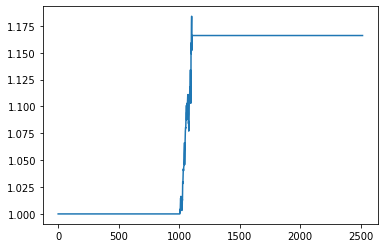

In [86]:
plt.plot(result.netvalue)
plt.show()